# Part 3. Variational Autoencoder (VAE) — 15 points

Useful links: 
* Original paper http://arxiv.org/abs/1312.6114
* Helpful videos explaining the topic 
   * https://www.youtube.com/watch?v=P78QYjWh5sM     
   * http://videolectures.net/deeplearning2015_courville_autoencoder_extension/?q=aaron%20courville

In this homework we will train an autoencoder to model images of faces. For this we take "Labeled Faces in the Wild" dataset (LFW) (http://vis-www.cs.umass.edu/lfw/), deep funneled version of it. (frontal view of all faces)


### Prepare the data

In [0]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import matplotlib.pyplot as plt
from IPython import display

%matplotlib inline

In [2]:
!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/hw3_19/homework03/lfw_dataset.py -O lfw_dataset.py

--2020-05-16 21:43:39--  https://raw.githubusercontent.com/yandexdataschool/Practical_DL/hw3_19/homework03/lfw_dataset.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2734 (2.7K) [text/plain]
Saving to: ‘lfw_dataset.py’

lfw_dataset.py      100%[===================>]   2.67K  --.-KB/s    in 0s      

2020-05-16 21:43:40 (27.9 MB/s) - ‘lfw_dataset.py’ saved [2734/2734]



In [0]:
#@title Utility functions
import numpy as np
import os
import skimage.io
import skimage
import skimage.transform
import pandas as pd

def fetch_lfw_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      raw_images_name = "lfw",
                      use_raw=False,
                      dx=80,dy=80,
                      dimx=45,dimy=45
    ): # sad smile

    #download if not exists
    if (not use_raw) and not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)
    
    if use_raw and not os.path.exists(raw_images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(raw_images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    dirname = raw_images_name if use_raw else images_name
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(dirname):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)

    #mass-merge
    #(photos now have same order as attributes)
    df_attrs['imagenum'] = df_attrs['imagenum'].astype(np.int64)
    df = pd.merge(df_attrs, photo_ids, on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    #image preprocessing
    all_photos = df['photo_path'].apply(lambda img: skimage.io.imread(img))\
                                 .apply(lambda img:img[dy:-dy,dx:-dx])\
                                 .apply(lambda img: skimage.img_as_ubyte(skimage.transform.resize(img,[dimx,dimy])))

    all_photos = np.stack(all_photos.values).astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos,all_attrs

In [0]:
data,attrs = fetch_lfw_dataset(dimx=36,dimy=36)

In [0]:
data = data/255
np.savez("real.npz", Pictures=data.reshape(data.shape[0], 36*36*3))

In [6]:
X_train = data[:10000].reshape((10000, -1))
print(X_train.shape)
X_val = data[10000:].reshape((-1, X_train.shape[1]))
print(X_val.shape)

image_h = data.shape[1]
image_w = data.shape[2]

(10000, 3888)
(3143, 3888)


For simplicity we want all values of the data to lie in the interval $[0,1]$:

In [0]:
X_train = np.float32(X_train)
X_val = np.float32(X_val)

In [0]:
def plot_gallery(images, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())

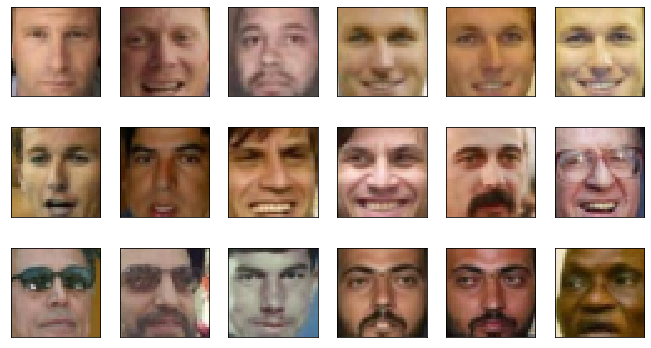

In [10]:
plot_gallery(X_train, image_h, image_w)

In [0]:
train = data_utils.TensorDataset(torch.Tensor(X_train), torch.zeros(X_train.shape[0],)) # pseudo labels needed to define TensorDataset
train_loader = data_utils.DataLoader(train, batch_size=100, shuffle=True)

val = data_utils.TensorDataset(torch.Tensor(X_val), torch.zeros(X_val.shape[0],))
val_loader = data_utils.DataLoader(val, batch_size=1, shuffle=False)

## Autoencoder

Why to use all this complicated formulas and regularizations, what is the need for variational inference? To analyze the difference, let's first train just an autoencoder on the data:

<img src="https://lilianweng.github.io/lil-log/assets/images/autoencoder-architecture.png" alt="Autoencoder">

In [0]:
dimZ = 100 # Considering face reconstruction task, which size of representation seems reasonable?

# Define the decoder and encoder as networks with one hidden fc-layer
# (that means you will have 2 fc layers in each net)
# Use ReLU for hidden layers' activations
# GlorotUniform initialization for W
# Zero initialization for biases
# It's also convenient to put sigmoid activation on output layer to get nice normalized pics

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        #TODO
        def init_weights(m): 
            if type(m) == nn.Linear:  
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.0)  

        self.encoder = nn.Sequential(nn.Linear(in_features = 36 * 36 * 3, out_features=1000),
                                     nn.BatchNorm1d(num_features = 1000),
                                     nn.ReLU(),
                                     nn.Linear(in_features = 1000, out_features = dimZ)).apply(init_weights)

        self.decoder = nn.Sequential(nn.Linear(in_features = dimZ, out_features = 1000),
                                     nn.BatchNorm1d(num_features = 1000),
                                     nn.ReLU(),
                                     nn.Linear(in_features = 1000, out_features = 36 * 36 * 3),
                                     ).apply(init_weights)
        
    def forward(self, x):
        
        #TODO
        
        latent_code = self.encoder(x)
        reconstruction = self.decoder(latent_code)
        
        return reconstruction, latent_code

In [0]:
# Create MSE loss function
criterion = torch.nn.MSELoss().cuda()

autoencoder = Autoencoder().cuda()

# Use Adam optimizer
optimizer = optim.Adam(autoencoder.parameters())

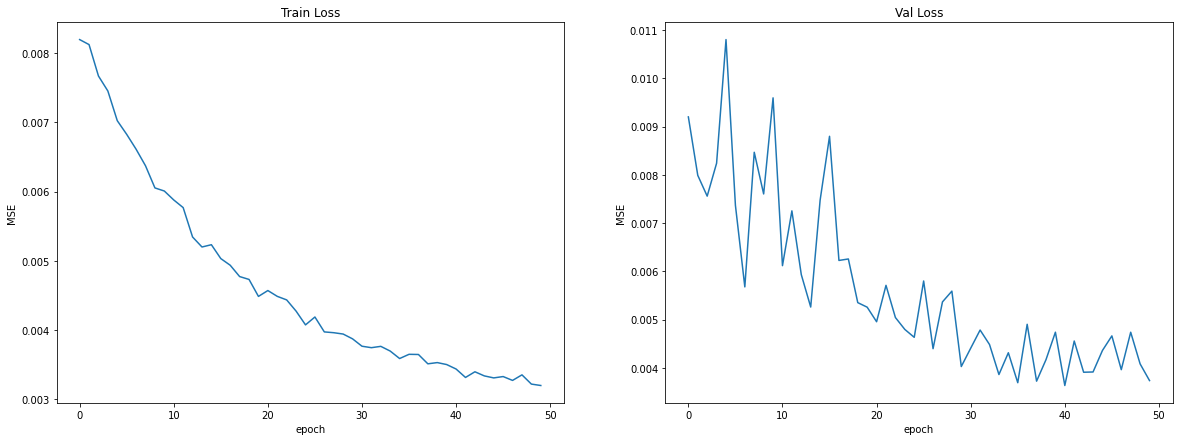

In [22]:
# Train your autoencoder
# Visualize progress in reconstruction and loss decay
num_epoches = 50

train_losses = []
val_losses = []
image_progress = []
for i in range(num_epoches):

    train_mse = 0
    val_mse = 0

    autoencoder.train()
    for X_batch, _ in train_loader:
        X_batch = X_batch.cuda()
        optimizer.zero_grad()
        output, latent_code = autoencoder.forward(X_batch)
        loss = criterion(output, X_batch)
        loss.backward()
        train_mse += loss/len(train_loader)
        optimizer.step()
    train_losses.append(train_mse)
    
    
    autoencoder.eval()
    if i%5:
        special_pred, _ = autoencoder.forward(train[11][0][None].cuda())
        image_progress.append(special_pred)

    for X_batch, _ in val_loader:
        X_batch = X_batch.cuda()
        output, latent_code = autoencoder.forward(X_batch)
        loss = criterion(output, X_batch)
        val_mse += loss/len(val_loader)
    val_losses.append(val_mse)

    #Visualization

    display.clear_output(wait=True)

    f, axarr = plt.subplots(1,2, figsize=(20,7))

    axarr[0].title.set_text("Train Loss")
    axarr[0].set_xlabel('epoch')
    axarr[0].set_ylabel('MSE')
    axarr[0].plot(train_losses)

    axarr[1].title.set_text("Val Loss")
    axarr[1].set_xlabel('epoch')
    axarr[1].set_ylabel('MSE')
    axarr[1].plot(val_losses)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


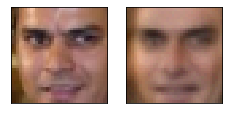

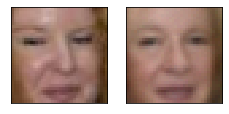

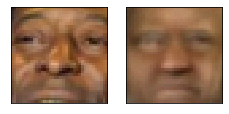

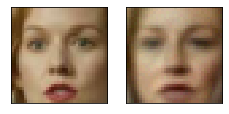

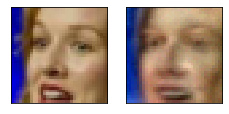

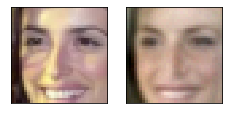

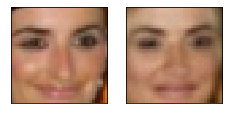

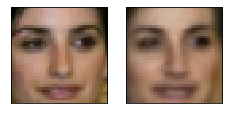

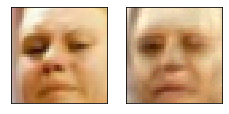

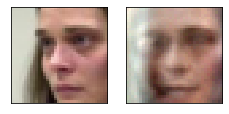

In [23]:
# Examine the reconstructions
for j, data in enumerate(val_loader, 0):
    inp = data[0].cuda()
    pred, _ = autoencoder(inp)
    plot_gallery([data[0].numpy(), pred.data.cpu().numpy()], image_h, image_w, n_row=1, n_col=2)
    if (j >= 9):
        break

Reconstruction is not bad, right? 

## Sampling

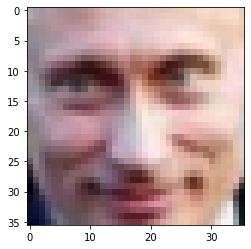

In [28]:
for i, (putin, y) in enumerate(val_loader):
    if i == 2754:
        break
plt.imshow(putin.numpy().reshape((image_w, image_w, 3)))

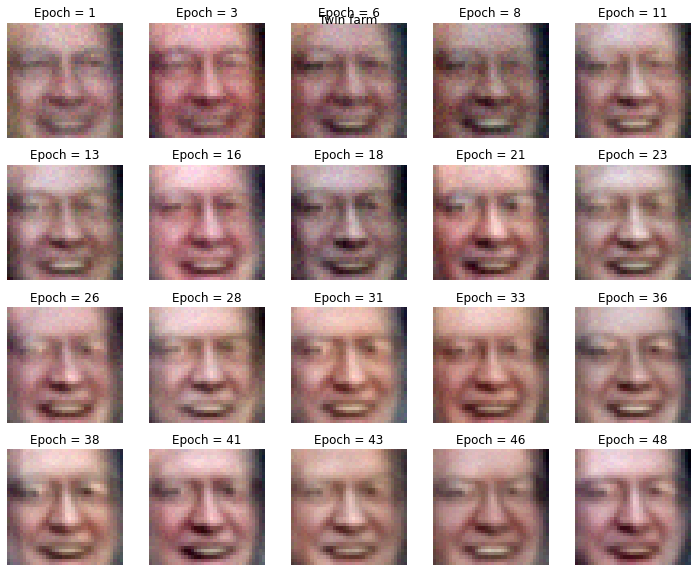

In [25]:
plt.figure(figsize=(10, 12))
plt.suptitle('Twin farm')
for i in range(len(image_progress[:20])):
    plt.subplots_adjust(bottom=0.0, left=.1, right=.9, top=.50, hspace=.15)
    plt.subplot(6, 5, 5*(i//5) + i % 5 + 1)
    plt.imshow(image_progress[i].clamp(0,1).data.cpu().numpy().reshape(image_w, image_h, 3))
    plt.title('Epoch = {}'.format(int(i * 2.5) +1))
    plt.axis('off')
plt.tight_layout()

Let's now sample several latent vectors and perform inference from $z$, reconstruct an image given some random $z$ representations.

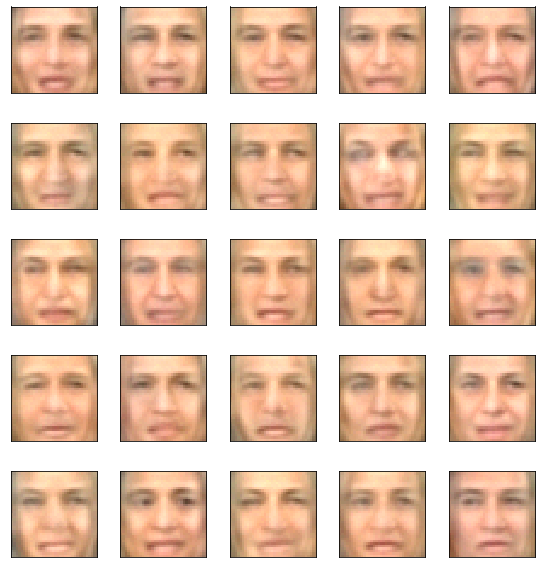

In [27]:
z = (np.random.randn(25, dimZ)*0.5).astype('float32')
output = autoencoder.decoder(torch.from_numpy(z).cuda()).clamp(0, 1)
plot_gallery(output.data.cpu().numpy(), image_h, image_w, n_row=5, n_col=5)

So, if we sample $z$ from normal, whould we eventually generate all possible faces? What do you think?

## Variational Autoencoder

Bayesian approach in deep learning considers everything in terms of distributions. Now our encoder generates not just a vector $z$ but posterior ditribution $q(z|x)$. In our case distribution $q$ is Gaussian distibution $N(\mu, \sigma)$ with parameters $\mu$, $\sigma$. Technically, the first difference is that you need to split bottleneck layer in two. One dense layer will generate vector $\mu$, and another will generate vector $\sigma$. Reparametrization trick should be implemented using the **gaussian_sampler** layer, that generates random vetor $\epsilon$ and returns $\mu+\sigma\epsilon \sim N(\mu, \sigma)$ .

Since our decoder is also a function that generates distribution, we need to do the same splitting for output layer. When testing the model we will look only on mean values, so one of the output will be actual autoencoder output.

In this homework we only ask for implementation of the simplest version of VAE - one $z$ sample per input. You can consider to sample several outputs from one input and average them.

In [0]:
# to compare with conventional AE, keep these hyperparameters
# or change them for the values that you used before
dimZ = 100

# define the network
# you can start from https://github.com/pytorch/examples/blob/master/vae/main.py
# or Theano-based examples here https://github.com/Lasagne/Recipes/blob/master/examples/variational_autoencoder/variational_autoencoder.py
# and here https://github.com/y0ast/Variational-Autoencoder/blob/master/VAE.py
# but remember that this is not your ground truth since the data is not MNIST

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        #TODO

        self.fc1 = nn.Sequential(nn.Linear(in_features = 36 * 36 * 3, out_features=1000),
                                 nn.BatchNorm1d(num_features = 1000),
                                 nn.ReLU())
        
        self.fc21 = nn.Sequential(nn.Linear(in_features = 1000, out_features=dimZ),
                                  nn.BatchNorm1d(num_features = dimZ))
        
        self.fc22 = nn.Sequential(nn.Linear(in_features = 1000, out_features=dimZ),
                                  nn.BatchNorm1d(num_features = dimZ))
        
        self.fc3 = nn.Sequential(nn.Linear(in_features = dimZ, out_features = 1000),
                                        nn.BatchNorm1d(num_features = 1000),
                                        nn.ReLU())
        
        self.decoder_mu = nn.Sequential(nn.Linear(in_features = 1000, out_features = 36 * 36 * 3),
                                     #nn.Sigmoid()
                                     )
        self.decoder_logsigma = nn.Sequential(nn.Linear(in_features = 1000, out_features = 36 * 36 * 3),
                                            #nn.Sigmoid()
                                            )
    def encoder(self, x):
        h1 = self.fc1(x)
        return self.fc21(h1), self.fc22(h1)

    def decoder(self, x):
        h1 = self.fc3(x)
        reconstruction_mu = self.decoder_mu(h1)
        reconstruction_logsigma = self.decoder_logsigma(h1)
        return reconstruction_mu, reconstruction_logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = logsigma.exp()
            eps = std.data.new(std.size()).normal_()
            return eps.mul(std).add(mu)
        else:
            return mu

    def forward(self, x):
        
        #TODO
        latent_mu, latent_logsigma = self.encoder(x)
        sample = self.gaussian_sampler(mu = latent_mu, logsigma = latent_logsigma)
        reconstruction_mu, reconstruction_logsigma = self.decoder(sample)
        return reconstruction_mu, reconstruction_logsigma, latent_mu, latent_logsigma

And the last, but not least! Place in the code where the most of the formulaes goes to - optimization objective. The objective for VAE has it's own name - variational lowerbound. And as for any lowerbound our intention is to maximize it. Here it is (for one sample $z$ per input $x$):

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Your next task is to implement two functions that compute KL-divergence and the second term - log-likelihood of an output. Here is some necessary math for your convenience:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$
$$\log p_{\theta}(x|z) = \sum_{i=1}^{dimX}\log p_{\theta}(x_i|z)=\sum_{i=1}^{dimX} \log \Big( \frac{1}{\sigma_i\sqrt{2\pi}}e^{-\frac{(\mu_i-x)^2}{2\sigma_i^2}} \Big)=...$$

Don't forget in the code that you are using $\log\sigma$ as an input. Explain, why not $\sigma$?

In [0]:
import math

def KL_divergence(mu, logsigma):
    return -1/2 * torch.sum(1 + 2 * logsigma - mu**2 - torch.exp(2 * logsigma))

def log_likelihood(x, mu, logsigma):
    return torch.sum(- (mu - x)**2 / (2 * torch.exp(2 * logsigma)) - logsigma - 1/2 * torch.log(torch.tensor(2 * math.pi)))

def loss_vae(x, mu_gen, logsigma_gen, mu_z, logsigma_z):
    return KL_divergence(mu_z, logsigma_z) - log_likelihood(x, mu_gen, logsigma_gen)

And train the model:

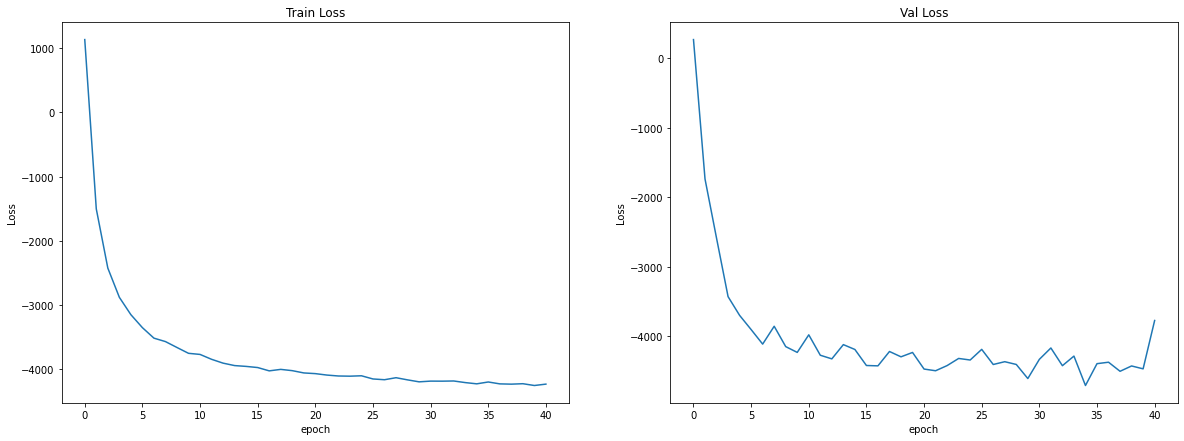

Ground Truth: 


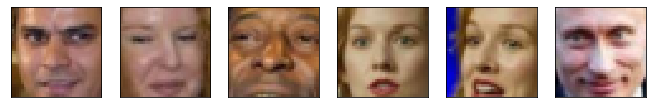

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Reconstruction: 


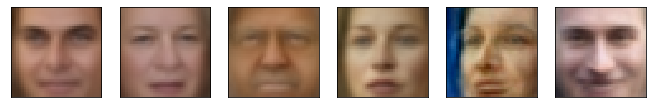

In [48]:
# train your autoencoder
# visualize progress in reconstruction and loss decay
train_loader = data_utils.DataLoader(train, batch_size=10, shuffle=True) # decrease batch_size bcs cuda run out of memory

vae = VAE().cuda()

optimizer = optim.Adam(vae.parameters())

num_epoches = 30

train_losses = []
val_losses = []

true = [X_val[i] for i in [0, 1, 2, 3, 4, 2754]] # images to check progress in reconstruction

for i in range(num_epoches):

    train_loss = 0
    val_loss = 0

    vae.train()
    for X_batch, _ in train_loader:
        X_batch = X_batch.cuda()
        optimizer.zero_grad()
        reconstruction_mu, reconstruction_logsigma, latent_mu, latent_logsigma = vae.forward(X_batch)
        loss = loss_vae(X_batch, reconstruction_mu, reconstruction_logsigma, latent_mu, latent_logsigma)
        loss.backward()
        train_loss += loss
        optimizer.step()
    train_losses.append(train_loss/len(X_train))

    vae.eval()
    for X_batch, _ in val_loader:
        X_batch = X_batch.cuda()
        reconstruction_mu, reconstruction_logsigma, latent_mu, latent_logsigma = vae.forward(X_batch)
        loss = loss_vae(X_batch, reconstruction_mu, reconstruction_logsigma, latent_mu, latent_logsigma)
        val_loss += loss
    val_losses.append(val_loss/len(X_val))

    #Visualization

    display.clear_output(wait=True)

    f, axarr = plt.subplots(1,2, figsize=(20,7))

    axarr[0].title.set_text("Train Loss")
    axarr[0].set_xlabel('epoch')
    axarr[0].set_ylabel('Loss')
    axarr[0].plot(train_losses)

    axarr[1].title.set_text("Val Loss")
    axarr[1].set_xlabel('epoch')
    axarr[1].set_ylabel('Loss')
    axarr[1].plot(val_losses)
    plt.show()

    reconstructed_faces = [vae(val.tensors[0].cuda())[0][i].cpu().detach().numpy() for i in [0, 1, 2, 3, 4, 2754]]
    
    print('Ground Truth: ')
    plot_gallery(true, image_h, image_w, n_row = 1, n_col = 6)
    plt.show()
    
    print('Reconstruction: ')
    plot_gallery(reconstructed_faces, image_h, image_w, n_row = 1, n_col = 6)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


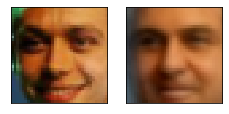

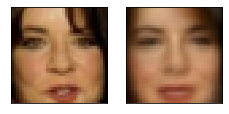

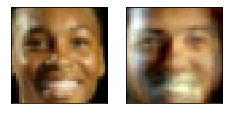

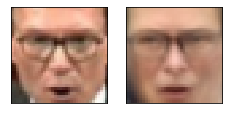

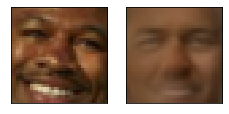

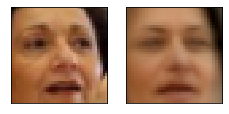

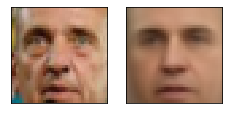

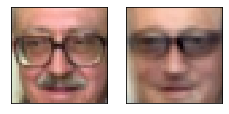

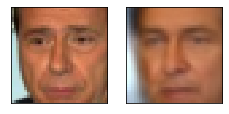

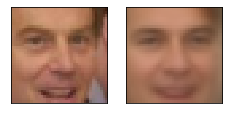

In [49]:
val_loader = data_utils.DataLoader(val, batch_size=1, shuffle=True)
vae.eval()
for j, data in enumerate(val_loader, 0):
    input = data[0].cuda()
    reconstruction_mu, _, _, _ = vae(input)
    plot_gallery([data[0].numpy(), reconstruction_mu.data.cpu().numpy()], image_h, image_w, n_row=1, n_col=2)
    if (j >= 9):
        break

And finally sample from VAE.

Sampled faces:


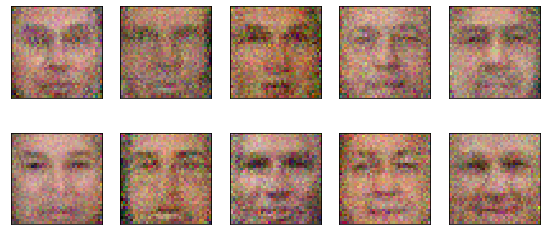

In [57]:
# TODO
# Sample some images from the learned distribution
# 1) Sample z ~ N(0,1)
# 2) Sample from N(decoder_mu(z), decoder_sigma(z))

z_rand = torch.tensor(np.random.randn(10, dimZ)).cuda().float()

dec1 = vae.fc3(z_rand)
reconstruction_mu = vae.decoder_mu(dec1)
reconstruction_logsigma = vae.decoder_logsigma(dec1)

z_learned = torch.distributions.Normal(reconstruction_mu, reconstruction_logsigma.exp())
frankensteins = z_learned.sample(torch.Size([8])).clamp(0, 1)
#frankensteins = (z_learned.sample(torch.Size([8]))+1)/2
print('Sampled faces:')
plot_gallery(frankensteins[0].detach().cpu().numpy(), image_h, image_w, n_row = 2, n_col = 5)
plt.show()

Even if in practice you do not see the much difference between AE and VAE, or VAE is even worse, the little bayesian inside you should be jumping for joy right now. 

In VAE you can truly sample from image distribution $p(x)$, while in AE there is no easy and correct way to do it. 

### If you are going to do part 4 (presicion-recall score): 

In [0]:
# using your model, generate face set with len = len(data)
z = torch.tensor(np.random.randn(len(data), dimZ)).cuda().float()
faces = vae.decoder(z)
answ = faces[0].detach().cpu().numpy()

### Save it ot npz

In [0]:
np.savez("vae.npz", Pictures=answ)

## Congrats! and Bonus

If you managed to tune your autoencoders to converge and learn something about the world, now it's time to make fun out of it. As you may have noticed, there are face attributes in dataset. We're interesting in "Smiling" column, but feel free to try others as well! Here is the first task:

1) Extract the "Smilling" attribute and create a two sets of images: 10 smiling faces and 10 non-smiling ones.

2) Compute latent representations for each image in "smiling" set and average those latent vectors. Do the same for "non-smiling" set. You have found **"vector representation"** of the "smile" and "no smile" attribute.

3) Compute the difference: "smile" vector minus "non-smile" vector.

3) Now check if **"feature arithmetics"** works. Sample a face without smile, encode it and add the diff from p. 3. Check if it works with both AE and VAE. 

In [0]:
# TODO
data,attrs = fetch_lfw_dataset(dimx=36,dimy=36)
data = data/255

Smiling ppl
Andre Agassi!! world No. 1 Tennis player, Smiling as always


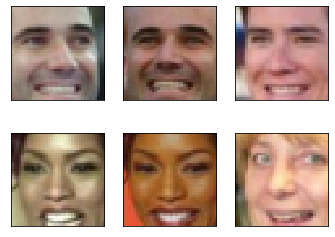

:/ ppl


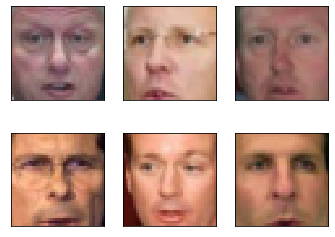

In [88]:
smiling_ppl = data[attrs['Smiling'].values > 2][20:27]
nonsmiling_ppl = data[attrs['Smiling'].values < -2][20:27]

print('Smiling ppl')
print('Andre Agassi!! world No. 1 Tennis player, Smiling as always')
plot_gallery(smiling_ppl, image_h, image_w, n_row = 2, n_col = 3)
plt.show()
print(':/ ppl')
plot_gallery(nonsmiling_ppl, image_h, image_w, n_row = 2, n_col = 3)
plt.show()

In [0]:
smile_repr = torch.tensor(smiling_ppl.reshape(-1, 3*36*36))
nonsmile_repr = torch.tensor(nonsmiling_ppl.reshape(-1, 3*36*36))

smile_latent_code, _ = vae.encoder(smile_repr.float().cuda())
nonsmile_latent_code, _ = vae.encoder(nonsmile_repr.float().cuda())

difference = smile_latent_code.mean(dim = 0) - nonsmile_latent_code.mean(dim = 0)

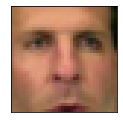

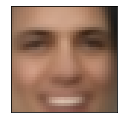

:/ --> :D


In [100]:
angry = nonsmile_repr[5].float()
plot_gallery(angry.detach().cpu().numpy().reshape(-1, 36, 36, 3), image_h, image_w, n_row = 1, n_col = 1)
plt.show()

add_smile = vae.encoder(angry.cuda()[None])[0] + difference.data
add_smile = vae.decoder(add_smile)[0]

plot_gallery(add_smile.detach().cpu().numpy().reshape(-1, 36, 36, 3), image_h, image_w, n_row = 1, n_col = 1)
plt.show()
print(':/ --> :D')